### Machine Learning Model Development

1. Datasource:
    - https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

2. Objective:
    - To classify a person into abnormal or normal using collected physical spine data.
    
3. Encoding:
    - Normal = 0 | Abnormal(Patient) = 1
    
4. Metrics:
    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    - However, my focus would be to improve the overall accuracy as well.
    
5. Scope:
    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

6. Target:
    - Test Accuracy >= 90%
    - Recall >= 90%
    
7. Recommendation from Exploratory Data Analyses (EDA)
    - Drop pelvic_incidence
    - Use StandarScaler.
    - Downsampling / Upsampling.

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\Back_Pain_"

# Specify number of features and targets

n_features = 12
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

df=df.drop(columns='pelvic_incidence')

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [15]:
# """
#     1. Cell for removing outliers.
#     2. Based on Z-score.
# """
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |     310 |  21.322 |  8.639 |   7.027 |  13.054 |  21.907 |  28.954 |  36.744 |
| thoracic_slope           |

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

Before Downsampling: 1    165
0     83
Name: Class_att, dtype: int64
After Undersampling: 0    83
1    83
Name: Class_att, dtype: int64


In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,23.138,62.582,42.474,124.128,-4.083,0.997,30.042,17.622,13.391,-16.370,21.450
1,15.969,35.000,35.655,129.385,1.009,0.005,32.420,13.815,11.285,-25.771,35.619
2,13.879,20.243,22.543,126.077,0.180,0.686,8.391,10.870,7.274,-26.196,21.846
3,10.063,37.000,36.174,128.064,-5.100,0.861,9.591,15.177,16.500,-22.420,40.206
4,16.209,36.675,23.448,131.922,-4.969,0.795,31.374,18.353,13.161,-6.653,26.330


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
119,21.936,82.962,54.211,123.932,10.432,0.253,21.593,7.810,11.071,-34.898,43.149
266,15.724,58.619,58.841,105.417,0.599,0.118,18.055,15.624,10.546,-32.495,16.623
217,20.268,77.111,63.435,125.480,69.280,0.736,33.812,15.112,14.381,-20.214,11.735
21,34.311,78.423,49.086,110.467,49.672,0.772,24.926,7.624,13.236,-21.450,16.215
61,33.426,76.277,45.000,138.554,77.155,0.581,36.628,16.626,7.965,-19.123,16.143


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Class_att
0,0
1,0
2,0
3,0
4,0


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Class_att
119,1
266,0
217,1
21,1
61,1


In [30]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.718106,0.759340,0.076779,0.386680,-0.570791,1.869011,1.091876,1.382402,0.536463,-0.167112,-0.363809
1,-0.032431,-0.807282,-0.430941,0.833924,-0.444390,-1.579937,1.368695,0.242083,-0.152943,-0.915962,1.028224
2,-0.251237,-1.645460,-1.407215,0.552493,-0.464969,0.787738,-1.428480,-0.640039,-1.465958,-0.949816,-0.324904
3,-0.650742,-0.693684,-0.392298,0.721539,-0.596036,1.396172,-1.288790,0.650046,1.554205,-0.649034,1.478873
4,-0.007304,-0.712144,-1.339832,1.049761,-0.592784,1.166705,1.246932,1.601359,0.461172,0.606909,0.115626


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.592267,1.916898,0.950675,0.370005,-0.210480,-0.717700,0.108342,-1.556607,-0.222997,-1.642986,1.768008
1,-0.058080,0.534247,1.295409,-1.205173,-0.454568,-1.187063,-0.303510,0.783937,-0.394857,-1.451572,-0.838038
2,0.417640,1.584568,1.637462,0.501703,1.250326,0.961576,1.530735,0.630576,0.860543,-0.473312,-1.318259
3,1.887830,1.659088,0.569085,-0.775540,0.763589,1.086740,0.496331,-1.612319,0.485723,-0.571767,-0.878122
4,1.795178,1.537198,0.264856,1.613984,1.445810,0.422678,1.858541,1.084068,-1.239756,-0.386407,-0.885195


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [36]:
print("------ Logistic Regression Best Parameters")

------ Logistic Regression Best Parameters


In [37]:
LR_Best

{'C': 10,
 'class_weight': {0: 1, 1: 1.05},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [38]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [39]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [40]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [41]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.65,0.76,0.70,17.00
1,0.90,0.84,0.87,45.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.78,0.80,0.79,62.00
weighted avg,0.83,0.82,0.83,62.00


In [ ]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5, 2]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

In [43]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [44]:
RFC_Best

{'class_weight': {0: 1, 1: 1.5},
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 200}

In [45]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [46]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [47]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [48]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.77,0.59,0.67,17.00
1,0.86,0.93,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.81,0.76,0.78,62.00
weighted avg,0.83,0.84,0.83,62.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [10000, 1000, 100]
gamma = [0.001, 0.01]
weights = [1.05, 1.5, 2]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

In [50]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [51]:
KSV_Best

{'C': 100, 'class_weight': {0: 1, 1: 2}, 'gamma': 0.001, 'kernel': 'linear'}

In [52]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [53]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [54]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [55]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.71,0.73,17.00
1,0.89,0.91,0.90,45.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.82,0.81,0.81,62.00
weighted avg,0.85,0.85,0.85,62.00


In [ ]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.03, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [50, 100, 150]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_state=RND_STATE)

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

In [57]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [58]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'random_state': 39,
 'depth': 10,
 'l2_leaf_reg': 1,
 'iterations': 50,
 'learning_rate': 0.1}

In [ ]:
# Model: CatBoost Classification (CBC)

CBC = cb.CatBoostClassifier(**CBC_Best)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [60]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [61]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [62]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.54,0.76,0.63,17.00
1,0.89,0.76,0.82,45.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.72,0.76,0.73,62.00
weighted avg,0.80,0.76,0.77,62.00


In [ ]:
# Neural Net Model

n_features = X_train.shape[1]

n_input = len(featlst)+1
n_hidden = 2*n_input
batch_size = int(y_train.shape[0]/10)

# define model

model = Sequential()
model.add(Dense(n_input, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dense(n_hidden, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=1000, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [64]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [65]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [66]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.54,0.88,0.67,17.00
1,0.94,0.71,0.81,45.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.74,0.80,0.74,62.00
weighted avg,0.83,0.76,0.77,62.00


In [67]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [68]:
print("Evaluation Summary:")

Evaluation Summary:


In [ ]:
summary.head(nmodels)

In [70]:
print("ROC Curve: ")

ROC Curve: 


In [ ]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [72]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [73]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [ ]:
Classification_Report_Summary

### Iteration 3

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Downsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = ['pelvic_incidence']

Output:

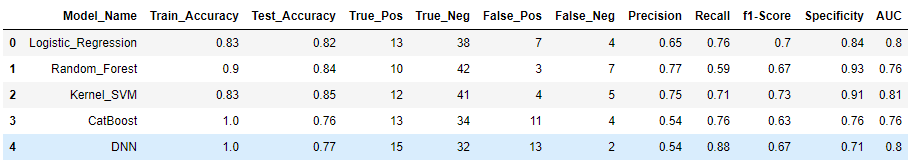

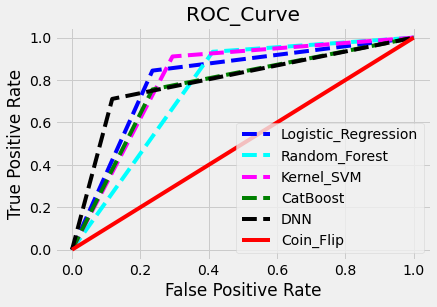

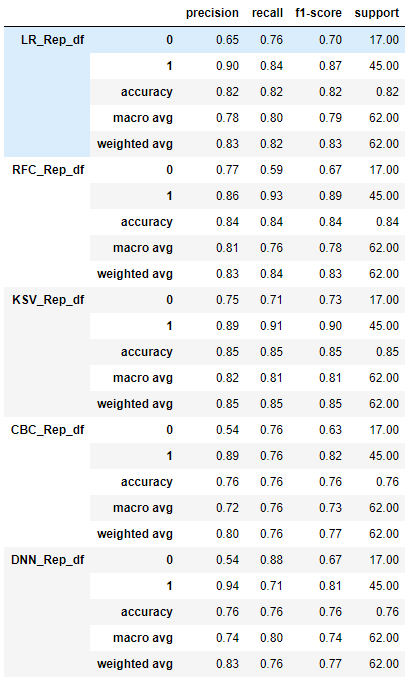

Conclusions / Recommendations:
    1. Downsampling not recommended. Recall has taken the turn for the worst.
    2. Iteration 3 will not be pursued further.
    3. Iteration # 2 will be the baseline against which improvement will be targeted.

### Iteration 2

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Upsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = ['pelvic_incidence']

Output:

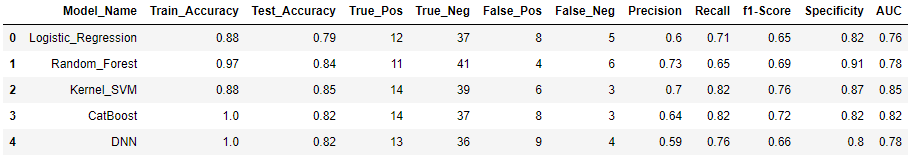

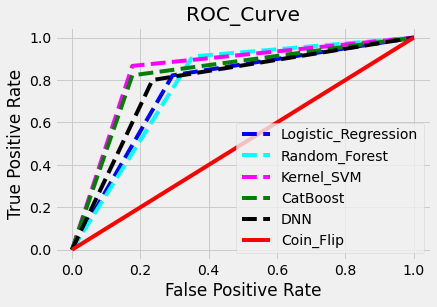

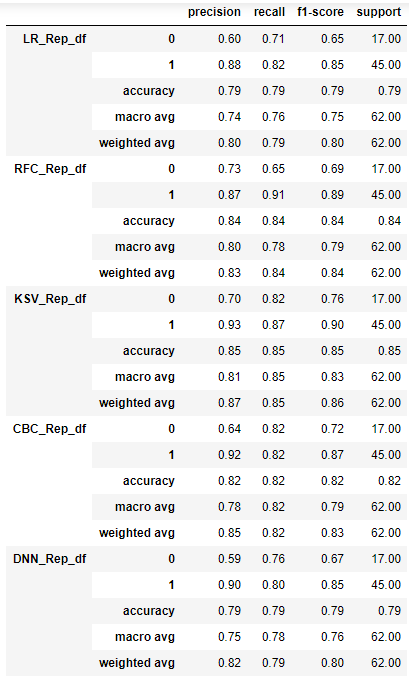

Conclusions / Recommendations:
    1. No significant impact of removing pelvic_incidence.
    2. Though recall for Catboost is higher than SVM, train and test accuracy differ by a large margin.
    3. Scores are below the target. Scope for improvement exists.

### Iteration 1

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Upsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = []

Output:

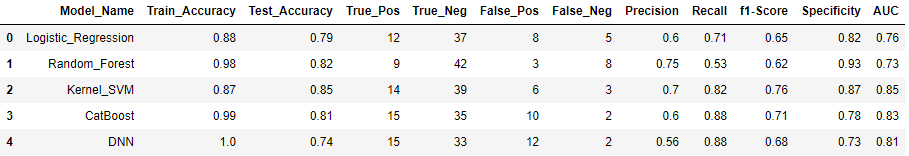

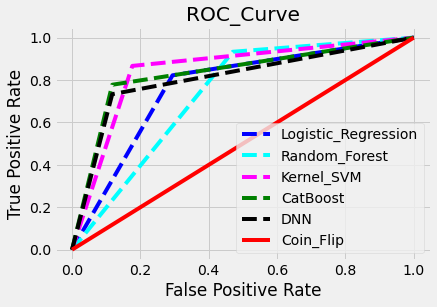

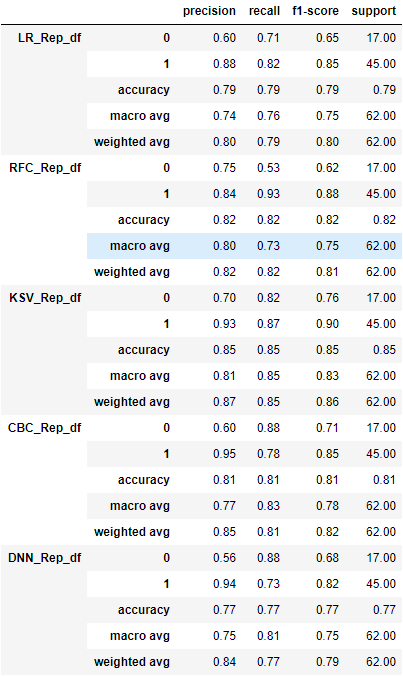

Conclusions / Recommendations:
    1. Objective of the project is to have the best recall and accuracy. Keeping this in mind, Kernel SVM seems better.
    2. Though recall for Catboost is higher than SVM, train and test accuracy differ by a large margin.
    3. Scores are below the target. Scope for improvement exists.

In [8]:
!jupyter nbconvert --output-dir='C:\DSML_Case_Studies\01_Classification\00_Final_Reports' MLM_CLF_Dataset_Back_Pain_R1.ipynb --to html

C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports' instead of "'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports'" – or use CUnicode.
  warn(
[NbConvertApp] Converting notebook MLM_CLF_Dataset_Back_Pain_R1.ipynb to html
[NbConvertApp] Writing 1117350 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Back_Pain_R1.html
